In [2]:
pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 15.4 MB/s eta 0:00:00:00:010:01
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566166 sha256=47a023bde1fbae6c4ca5a4055cad85a65dc90dd6dfdaa7693a2816abf4d7a28c
  Stored in directory: /root/.cache/pip/wheels/04/52/ec/9355da79c29f160b038a20c784db2803c2f9fa2c8a462c176a
Successfully built face-recognition-models
Note: you may need to restart the kernel to use updated packages.


In [16]:
import shutil
from pathlib import Path

def merge_subfolders(first_root, second_root, common_folder, num_first=5):
    first_root  = Path(first_root)
    second_root = Path(second_root)
    common      = Path(common_folder)

    # ensure output exists
    common.mkdir(parents=True, exist_ok=True)

    # 1) pick first N subfolders from first_root
    subs1 = sorted([d for d in first_root.iterdir() if d.is_dir()])[:num_first]
    for src in subs1:
        dst = common / src.name
        if dst.exists():
            print(f"⚠️  Skipping {dst} (already exists)")
            continue
        shutil.copytree(src, dst)
        print(f"✅  Copied {src} → {dst}")

    # 2) copy the entire second_root as a subfolder
    dst2 = common / second_root.name
    if dst2.exists():
        print(f"⚠️  Skipping {dst2} (already exists)")
    else:
        shutil.copytree(second_root, dst2)
        print(f"✅  Copied {second_root} → {dst2}")

if __name__ == "__main__":
    merge_subfolders(
        first_root    = r"/kaggle/input/face-recognition-dataset/Original Images/Original Images",
        second_root   = r"/kaggle/input/ahmed-karous",
        common_folder = r"CommonFolder",
        num_first     = 10
    )


✅  Copied /kaggle/input/face-recognition-dataset/Original Images/Original Images/Akshay Kumar → CommonFolder/Akshay Kumar
✅  Copied /kaggle/input/face-recognition-dataset/Original Images/Original Images/Alexandra Daddario → CommonFolder/Alexandra Daddario
✅  Copied /kaggle/input/face-recognition-dataset/Original Images/Original Images/Alia Bhatt → CommonFolder/Alia Bhatt
✅  Copied /kaggle/input/face-recognition-dataset/Original Images/Original Images/Amitabh Bachchan → CommonFolder/Amitabh Bachchan
✅  Copied /kaggle/input/face-recognition-dataset/Original Images/Original Images/Andy Samberg → CommonFolder/Andy Samberg
✅  Copied /kaggle/input/face-recognition-dataset/Original Images/Original Images/Anushka Sharma → CommonFolder/Anushka Sharma
✅  Copied /kaggle/input/face-recognition-dataset/Original Images/Original Images/Billie Eilish → CommonFolder/Billie Eilish
✅  Copied /kaggle/input/face-recognition-dataset/Original Images/Original Images/Brad Pitt → CommonFolder/Brad Pitt
✅  Copie

### 

In [18]:
import os
from imutils import paths
import face_recognition
import pickle
import cv2

DATASET_PATH = "/kaggle/working/CommonFolder"

print("[INFO] start processing faces...")
imagePaths = list(paths.list_images(DATASET_PATH))
knownEncodings = []
knownNames = []

for (i, imagePath) in enumerate(imagePaths):
    print(f"[INFO] processing image {i + 1}/{len(imagePaths)}")
    name = imagePath.split(os.path.sep)[-2]  # Extract folder name as label
    
    image = cv2.imread(imagePath)
    if image is None:
        print(f"[WARNING] Could not read image {imagePath}, skipping.")
        continue

    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    boxes = face_recognition.face_locations(rgb, model="hog")
    encodings = face_recognition.face_encodings(rgb, boxes)

    for encoding in encodings:
        knownEncodings.append(encoding)
        knownNames.append(name)

print("[INFO] serializing encodings...")
data = {"encodings": knownEncodings, "names": knownNames}
with open("encodings.pickle", "wb") as f:
    f.write(pickle.dumps(data))

print("[INFO] Training complete. Encodings saved to 'encodings.pickle'")


[INFO] start processing faces...
[INFO] processing image 1/850
[INFO] processing image 2/850
[INFO] processing image 3/850
[INFO] processing image 4/850
[INFO] processing image 5/850
[INFO] processing image 6/850
[INFO] processing image 7/850
[INFO] processing image 8/850
[INFO] processing image 9/850
[INFO] processing image 10/850
[INFO] processing image 11/850
[INFO] processing image 12/850
[INFO] processing image 13/850
[INFO] processing image 14/850
[INFO] processing image 15/850
[INFO] processing image 16/850
[INFO] processing image 17/850
[INFO] processing image 18/850
[INFO] processing image 19/850
[INFO] processing image 20/850
[INFO] processing image 21/850
[INFO] processing image 22/850
[INFO] processing image 23/850
[INFO] processing image 24/850
[INFO] processing image 25/850
[INFO] processing image 26/850
[INFO] processing image 27/850
[INFO] processing image 28/850
[INFO] processing image 29/850
[INFO] processing image 30/850
[INFO] processing image 31/850
[INFO] processi

### Test on single image 

In [6]:
import face_recognition
import cv2
import pickle
import os

# Load encodings
with open("encodings.pickle", "rb") as f:
    data = pickle.load(f)

# Replace this with your actual image
image_path = "/kaggle/working/commonFolder/ahmed-karous/ahmed_20250415_164658.jpg"

# Check file exists
if not os.path.exists(image_path):
    print(f"[ERROR] Image not found at: {image_path}")
    exit()

# Load the image
image = cv2.imread(image_path)
if image is None:
    print(f"[ERROR] Failed to read image: {image_path}")
    exit()

# Convert to RGB
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Detect and encode
boxes = face_recognition.face_locations(rgb, model="hog")
encodings = face_recognition.face_encodings(rgb, boxes)

for (box, encoding) in zip(boxes, encodings):
    matches = face_recognition.compare_faces(data["encodings"], encoding)
    name = "Unknown"

    if True in matches:
        matchedIdxs = [i for (i, b) in enumerate(matches) if b]
        counts = {}
        for i in matchedIdxs:
            counts[data["names"][i]] = counts.get(data["names"][i], 0) + 1
        name = max(counts, key=counts.get)

    # Draw result
    (top, right, bottom, left) = box
    cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)
    cv2.putText(image, name, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)

cv2.imwrite("output.jpg", image)
print("Output image saved to output.jpg")


Output image saved to output.jpg


In [19]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load encodings and labels
with open("/kaggle/working/encodings.pickle", "rb") as f:
    data = pickle.load(f)

from collections import Counter
import numpy as np

# Load encodings and labels
with open("encodings.pickle", "rb") as f:
    data = pickle.load(f)

X = np.array(data["encodings"])
y = np.array(data["names"])

# Count number of samples per class
class_counts = Counter(y)

# Keep only those with at least 2 samples
mask = np.array([class_counts[name] >= 2 for name in y])
X_filtered = X[mask]
y_filtered = y[mask]

X_train, X_val, y_train, y_val = train_test_split(
    X_filtered, y_filtered, test_size=0.25, random_state=42, stratify=y_filtered
)

# Train a linear SVM classifier
clf = SVC(kernel="linear", probability=True)
clf.fit(X_train, y_train)

# Predictions
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)

# Accuracy scores
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred, labels=np.unique(y))

# Save the model for inference
model_path = "/kaggle/working/face_classifier.joblib"
joblib.dump(clf, model_path)

# Prepare data for plots
results = {
    "train_accuracy": train_acc,
    "val_accuracy": val_acc,
    "confusion_matrix": cm,
    "labels": np.unique(y),
    "model_path": model_path
}
results


{'train_accuracy': 0.9906542056074766,
 'val_accuracy': 0.9906976744186047,
 'confusion_matrix': array([[13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0, 21,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0, 18,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0, 23,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  1,  0,  0, 16,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0, 24,  0,  0,  0,  0],
        [ 1,  0,  0,  0,  0,  0,  0, 30,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0, 22,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 20,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3]]),
 'labels': array(['Akshay Kumar', 'Alexandra Daddario', 'Alia Bhatt',
        'Amitabh Bachchan', 'Andy Samberg', 'Anushka Sharma',
        'Billie Eilish', 'Brad Pitt', 'Camila Cabello', 'Charlize Theron',
        'ahmed-karous'], dtype='<U18'),
 'model_path': '/kaggle/working/face_classifier.joblib'}

In [13]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load encodings and labels
with open("/kaggle/working/encodings.pickle", "rb") as f:
    data = pickle.load(f)

from collections import Counter
import numpy as np

# Load encodings and labels
with open("encodings.pickle", "rb") as f:
    data = pickle.load(f)

X = np.array(data["encodings"])
y = np.array(data["names"])

# Count number of samples per class
class_counts = Counter(y)

# Keep only those with at least 2 samples
mask = np.array([class_counts[name] >= 2 for name in y])
X_filtered = X[mask]
y_filtered = y[mask]

X_train, X_val, y_train, y_val = train_test_split(
    X_filtered, y_filtered, test_size=0.25, random_state=42
)

# Train a linear SVM classifier
clf = SVC(kernel="linear", probability=True)
clf.fit(X_train, y_train)

# Predictions
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)

# Accuracy scores
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred, labels=np.unique(y))

# Save the model for inference
model_path = "/kaggle/working/face_classifier.joblib"
joblib.dump(clf, model_path)

# Prepare data for plots
results = {
    "train_accuracy": train_acc,
    "val_accuracy": val_acc,
    "confusion_matrix": cm,
    "labels": np.unique(y),
    "model_path": model_path
}
results


{'train_accuracy': 0.9934426229508196,
 'val_accuracy': 0.9901960784313726,
 'confusion_matrix': array([[15,  0,  0,  0,  0,  0],
        [ 1, 19,  0,  0,  0,  0],
        [ 0,  0, 21,  0,  0,  0],
        [ 0,  0,  0, 22,  0,  0],
        [ 0,  0,  0,  0, 20,  0],
        [ 0,  0,  0,  0,  0,  4]]),
 'labels': array(['Akshay Kumar', 'Alexandra Daddario', 'Alia Bhatt',
        'Amitabh Bachchan', 'Andy Samberg', 'ahmed-karous'], dtype='<U18'),
 'model_path': '/kaggle/working/face_classifier.joblib'}

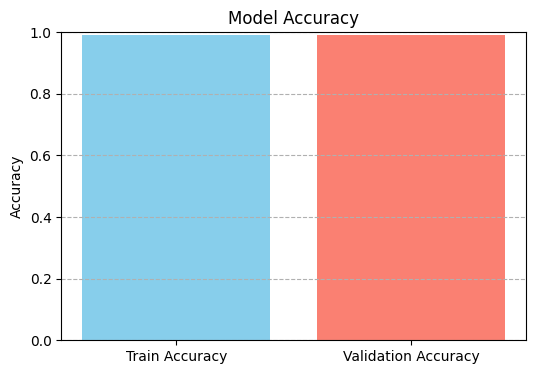

In [20]:
# Accuracy comparison bar plot
plt.figure(figsize=(6, 4))
plt.bar(['Train Accuracy', 'Validation Accuracy'], [train_acc, val_acc], color=['skyblue', 'salmon'])
plt.ylim(0, 1)
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.grid(axis='y', linestyle='--')
plt.show()

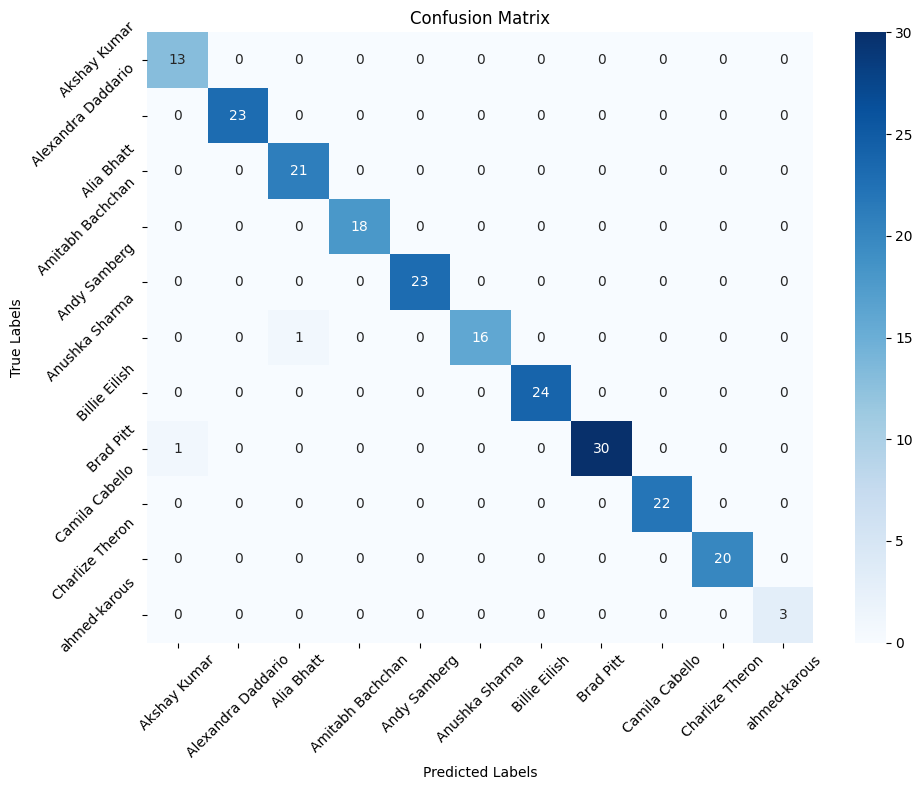

In [21]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


In [22]:
print("Classification Report:\n")
print(classification_report(y_val, y_val_pred))


Classification Report:

                    precision    recall  f1-score   support

      Akshay Kumar       0.93      1.00      0.96        13
Alexandra Daddario       1.00      1.00      1.00        23
        Alia Bhatt       0.95      1.00      0.98        21
  Amitabh Bachchan       1.00      1.00      1.00        18
      Andy Samberg       1.00      1.00      1.00        23
    Anushka Sharma       1.00      0.94      0.97        17
     Billie Eilish       1.00      1.00      1.00        24
         Brad Pitt       1.00      0.97      0.98        31
    Camila Cabello       1.00      1.00      1.00        22
   Charlize Theron       1.00      1.00      1.00        20
      ahmed-karous       1.00      1.00      1.00         3

          accuracy                           0.99       215
         macro avg       0.99      0.99      0.99       215
      weighted avg       0.99      0.99      0.99       215



In [9]:
!pip uninstall -y tensorflow
!pip install tensorflow==2.14.0


Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 3.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 94.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth

2025-05-25 07:58:16.788079: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748159897.074832      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748159897.150463      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 1/30


2025-05-25 07:58:33.829686: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.1405 - loss: 2.3381 - val_accuracy: 0.3581 - val_loss: 1.7763
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4780 - loss: 1.5458 - val_accuracy: 0.8837 - val_loss: 0.4401
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8623 - loss: 0.5192 - val_accuracy: 0.9674 - val_loss: 0.1533
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9226 - loss: 0.2537 - val_accuracy: 0.9628 - val_loss: 0.1017
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9180 - loss: 0.2193 - val_accuracy: 0.9674 - val_loss: 0.0982
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9535 - loss: 0.1812 - val_accuracy: 0.9767 - val_loss: 0.0892
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9633 - loss: 0.1700 - val_accuracy: 0.9814 - val_loss: 0.0705
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9690 - loss: 0.0998 - val_accuracy: 0.9860 - val_loss: 0.0553
Ep

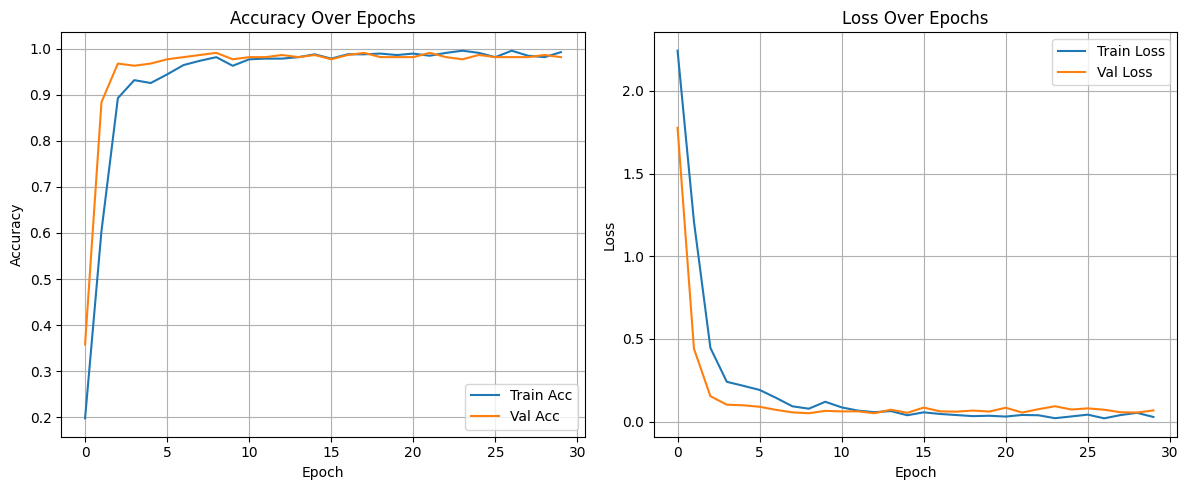

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Input

from tensorflow.keras.utils import to_categorical
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Load encodings
with open("/kaggle/input/finalenc/encodings (1).pickle", "rb") as f:
    data = pickle.load(f)

X = np.array(data["encodings"])
y = np.array(data["names"])

# Filter classes with at least 2 samples
from collections import Counter
class_counts = Counter(y)
mask = np.array([class_counts[name] >= 2 for name in y])
X_filtered = X[mask]
y_filtered = y[mask]

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_filtered)
y_cat = to_categorical(y_encoded)

# Train/test split
X_train, X_val, y_train, y_val = train_test_split(
    X_filtered, y_cat, test_size=0.25, random_state=42, stratify=y_cat
)

# Build model
model = Sequential([
    Input(shape=(X.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(y_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_val, y_val))

# Save model
model.save("face_classifier_nn.h5")

# === Plot training history ===
plt.figure(figsize=(12, 5))

# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


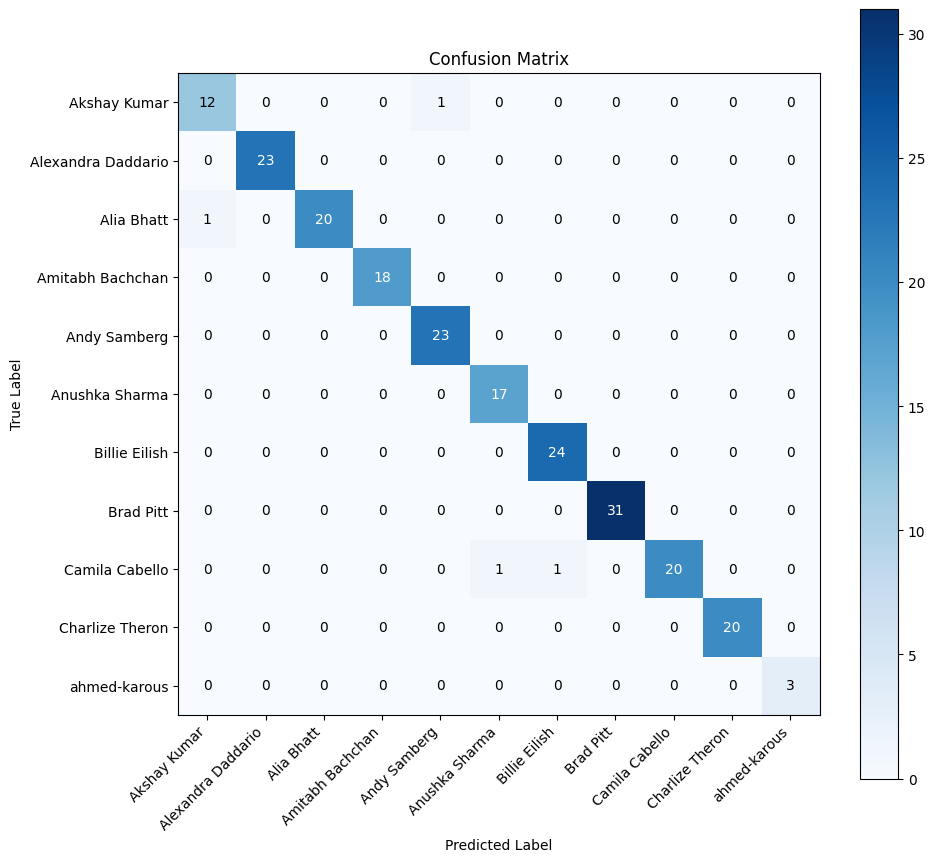

In [11]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# 1) Get model predictions on the validation set
y_pred_proba = model.predict(X_val)
y_pred = np.argmax(y_pred_proba, axis=1)

# 2) Decode true labels from one‐hot
y_true = np.argmax(y_val, axis=1)

# 3) Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 4) Plot it
plt.figure(figsize=(10,9))   # single plot
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()

# 5) Add class‐name ticks
classes = le.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, ha="right")
plt.yticks(tick_marks, classes)

# 6) Annotate counts
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, 
            format(cm[i, j]),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.tight_layout()
plt.show()
